In [3]:
# Lab 3 - MNIST Perceptron (Binary Classification: 0 vs 1)
import gzip
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

# Dataset folder and file constants
DATASET_FOLDER = 'mnist_data'
TRAIN_IMAGES_FILE = os.path.join(DATASET_FOLDER, 'train-images-idx3-ubyte.gz')
TRAIN_LABELS_FILE = os.path.join(DATASET_FOLDER, 'train-labels-idx1-ubyte.gz')
TEST_IMAGES_FILE = os.path.join(DATASET_FOLDER, 't10k-images-idx3-ubyte.gz')
TEST_LABELS_FILE = os.path.join(DATASET_FOLDER, 't10k-labels-idx1-ubyte.gz')

NROWS, NCOLS = 28, 28

In [4]:
def loadData():
    # Use tf.keras.datasets.mnist as backup when IDX files not available
    try:
        def readIdxImages(filename):
            with gzip.open(filename, 'rb') as f:
                magic, numImages, rows, cols = struct.unpack('>IIII', f.read(16))
                images = np.frombuffer(f.read(), dtype=np.uint8)
                return images.reshape(numImages, rows, cols)
        
        def readIdxLabels(filename):
            with gzip.open(filename, 'rb') as f:
                magic, numLabels = struct.unpack('>II', f.read(8))
                labels = np.frombuffer(f.read(), dtype=np.uint8)
                return labels
        
        trainIms = readIdxImages(TRAIN_IMAGES_FILE)
        trainLbs = readIdxLabels(TRAIN_LABELS_FILE)
        testIms = readIdxImages(TEST_IMAGES_FILE)
        testLbs = readIdxLabels(TEST_LABELS_FILE)
        print("Loaded from IDX files")
        
    except FileNotFoundError:
        print("IDX files not found, using tf.keras.datasets.mnist")
        import tensorflow as tf
        (trainIms, trainLbs), (testIms, testLbs) = tf.keras.datasets.mnist.load_data()
    
    return trainIms, trainLbs, testIms, testLbs

# Q1: Load data and print shapes
trainIms, trainLbs, testIms, testLbs = loadData()
print(f"Q1 - Data shapes:")
print(f"trainIms: {trainIms.shape}, trainLbs: {trainLbs.shape}")
print(f"testIms: {testIms.shape}, testLbs: {testLbs.shape}")

IDX files not found, using tf.keras.datasets.mnist
Q1 - Data shapes:
trainIms: (60000, 28, 28), trainLbs: (60000,)
testIms: (10000, 28, 28), testLbs: (10000,)


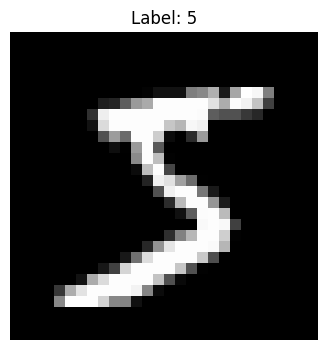

Q2 - Sample image label: 5


In [5]:
# Q2: Display sample image + label
sampleIdx = 0
plt.figure(figsize=(4, 4))
plt.imshow(trainIms[sampleIdx], cmap='gray')
plt.title(f'Label: {trainLbs[sampleIdx]}')
plt.axis('off')
plt.show()
print(f"Q2 - Sample image label: {trainLbs[sampleIdx]}")

In [6]:
# Q4/Q5: Filter to classes {0,1} 
trainMask = (trainLbs == 0) | (trainLbs == 1)
testMask = (testLbs == 0) | (testLbs == 1)

trainIms = trainIms[trainMask]
trainLbs = trainLbs[trainMask]
testIms = testIms[testMask]
testLbs = testLbs[testMask]

print(f"Q4 - Filtered training: {trainIms.shape[0]} samples")
print(f"Q5 - Filtered test: {testIms.shape[0]} samples")

Q4 - Filtered training: 12665 samples
Q5 - Filtered test: 2115 samples


In [7]:
# Q6: Split training into 80% train, 20% validation
splitIdx = int(0.8 * len(trainIms))
valIms = trainIms[splitIdx:]
valLbs = trainLbs[splitIdx:]
trainIms = trainIms[:splitIdx]
trainLbs = trainLbs[:splitIdx]

print(f"Q6 - Train split: {trainIms.shape[0]} samples")
print(f"Q6 - Validation split: {valIms.shape[0]} samples")

# Q7: Convert to float32
trainIms = trainIms.astype(np.float32)
valIms = valIms.astype(np.float32)  
testIms = testIms.astype(np.float32)
trainLbs = trainLbs.astype(np.float32)
valLbs = valLbs.astype(np.float32)
testLbs = testLbs.astype(np.float32)
print("Q7 - Converted to float32")

# Q8: Convert labels {0,1} → {-1,1}
trainLbs = 2 * trainLbs - 1
valLbs = 2 * valLbs - 1
testLbs = 2 * testLbs - 1
print("Q8 - Labels converted to {-1, +1}")

Q6 - Train split: 10132 samples
Q6 - Validation split: 2533 samples
Q7 - Converted to float32
Q8 - Labels converted to {-1, +1}


In [8]:
weights = np.random.normal(0.0, 1.0, size=(NROWS * NCOLS,))
eta = 0.1
print(f"Q10 - Learning rate eta: {eta}")

trainImsFlat = trainIms.reshape(-1, NROWS * NCOLS)
valImsFlat = valIms.reshape(-1, NROWS * NCOLS)
testImsFlat = testIms.reshape(-1, NROWS * NCOLS)

numTrainingSamples = len(trainIms)
numValSamples = len(valIms)

# Q9/Q11: Training loop with validation tracking
print("Q9 - Training progress:")
step = 0
bestValAcc = 0.0
terminatingStep = -1

for epoch in range(100):
    for i in range(numTrainingSamples):
        x = trainImsFlat[i]
        yTrue = trainLbs[i]
        
        yPred = np.sign(np.dot(weights, x))
        if yPred == 0:
            yPred = 1
        
        if yPred != yTrue:
            weights += eta * yTrue * x
        
        step += 1
        
        if step % 100 == 0:
            valCorrect = 0
            for j in range(numValSamples):
                valX = valImsFlat[j]
                valYTrue = valLbs[j]
                valYPred = np.sign(np.dot(weights, valX))
                if valYPred == 0:
                    valYPred = 1
                if valYPred == valYTrue:
                    valCorrect += 1
            
            valAcc = valCorrect / numValSamples
            print(f"Step {step}: Validation accuracy = {valAcc:.4f}")
            
            if valAcc >= 0.90 and terminatingStep == -1:
                terminatingStep = step
                print(f"Q11 - Early stopping at step: {terminatingStep}")
                break
    
    if terminatingStep != -1:
        break

Q10 - Learning rate eta: 0.1
Q9 - Training progress:
Step 100: Validation accuracy = 0.9787
Q11 - Early stopping at step: 100


Q12 - Test accuracy: 0.9882


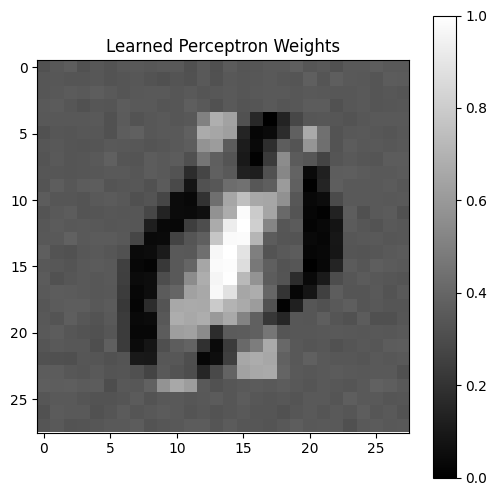

Q14 - The weight image shows the perceptron learned to distinguish digit shape patterns.


In [9]:
# Q12: Test evaluation
testCorrect = 0
numTestSamples = len(testIms)

for i in range(numTestSamples):
    testX = testImsFlat[i]
    testYTrue = testLbs[i]
    testYPred = np.sign(np.dot(weights, testX))
    if testYPred == 0:
        testYPred = 1
    if testYPred == testYTrue:
        testCorrect += 1

testAcc = testCorrect / numTestSamples
print(f"Q12 - Test accuracy: {testAcc:.4f}")

# Q13: Visualize learned weights
weightsImage = weights.reshape(NROWS, NCOLS)
weightsNorm = (weightsImage - weightsImage.min()) / (weightsImage.max() - weightsImage.min())

plt.figure(figsize=(6, 6))
plt.imshow(weightsNorm, cmap='gray')
plt.colorbar()
plt.title('Learned Perceptron Weights')
plt.show()

# Q14: Comment on weight pattern
print("Q14 - The weight image shows the perceptron learned to distinguish digit shape patterns.")